In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score


In [4]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


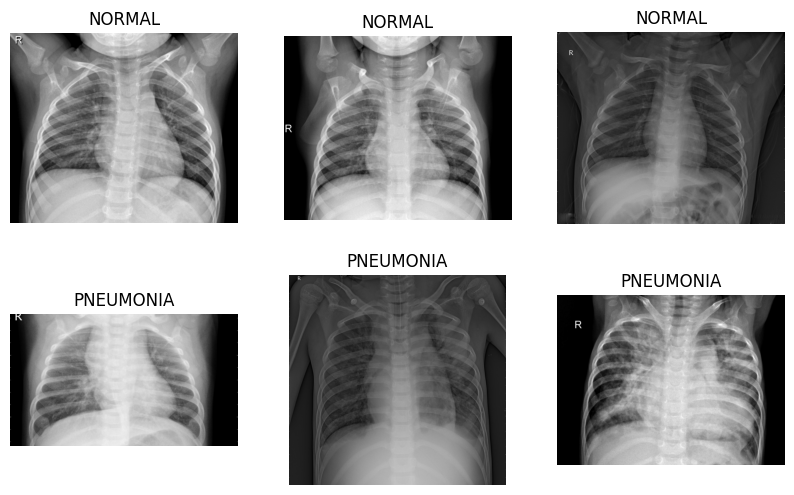

In [5]:
#display 3 images from each class.

import os
import matplotlib.pyplot as plt
from PIL import Image
import random

base_dir = os.path.join(path, "chest_xray")
classes = ["NORMAL", "PNEUMONIA"]

plt.figure(figsize=(10,6))
i = 1
for cls in classes:
    folder = os.path.join(base_dir, "train", cls)
    images = random.sample(os.listdir(folder), 3)
    for img in images:
        plt.subplot(2,3,i)
        plt.imshow(Image.open(os.path.join(folder, img)), cmap="gray")
        plt.title(cls)
        plt.axis("off")
        i += 1
plt.show()



In [6]:
for cls in classes:
    print(cls, ":", len(os.listdir(os.path.join(base_dir, "train", cls))))


NORMAL : 1341
PNEUMONIA : 3875


In [7]:
#Data Preprocessing

from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224,224)
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    os.path.join(base_dir,"train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_data = val_test_gen.flow_from_directory(
    os.path.join(base_dir,"val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_data = val_test_gen.flow_from_directory(
    os.path.join(base_dir,"test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
'''
Why is data augmentation important in medical images?

It reduces overfitting

It simulates the difference in actual X-ray angles

It compensates for a lack of medical data
'''

In [8]:
#CNN Model Design

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32,(3,3),activation="relu",input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64,(3,3),activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128,(3,3),activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128,activation="relu"),
    Dropout(0.5),
    Dense(1,activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:

#Model Training

history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 657s 4s/step - accuracy: 0.7718 - loss: 0.5743 - val_accuracy: 0.8125 - val_loss: 0.4588
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 606s 4s/step - accuracy: 0.8888 - loss: 0.2867 - val_accuracy: 0.6250 - val_loss: 0.8705
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 625s 4s/step - accuracy: 0.8994 - loss: 0.2437 - val_accuracy: 0.6250 - val_loss: 0.8713
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 606s 4s/step - accuracy: 0.9009 - loss: 0.2381 - val_accuracy: 0.7500 - val_loss: 0.6199
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 606s 4s/step - accuracy: 0.9144 - loss: 0.2188 - val_accuracy: 0.8750 - val_loss: 0.4660
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 609s 4s/step - accuracy: 0.9179 - loss: 0.1999 - val_accuracy: 0.6250 - val_loss: 0.9249
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 610s 4s/step - accuracy: 0.9317 - loss: 0.1831 - val_accuracy: 0.6250 - val_loss: 0.9324
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 603s 4s/step - accuracy: 0.9295 - loss: 0.1886 - val_accu

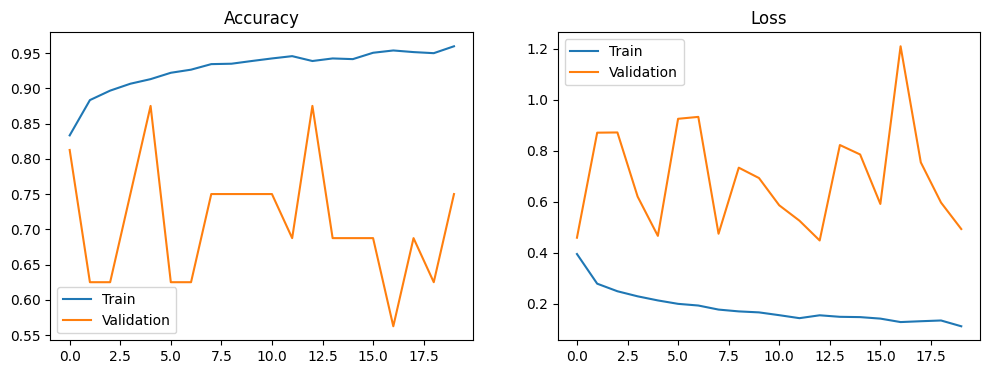

In [10]:



#Training vs Validation Accuracy
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

#Training vs Validation Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()


In [ ]:
'''

If training accuracy increases and verification accuracy decreases → Overfitting

A small difference between the two curves indicates a good model.

'''

In [11]:


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# التنبؤ
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_data.classes

# المقاييس
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# تقرير كامل
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Accuracy: 0.8990384615384616
Precision: 0.8741418764302059
Recall: 0.9794871794871794
F1-score: 0.9238210399032648

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.76      0.85       234
           1       0.87      0.98      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



In [12]:
#Model Evaluation

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

pred = model.predict(test_data)
pred_classes = (pred > 0.5).astype(int)

print(classification_report(test_data.classes, pred_classes))



20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       234
           1       0.87      0.98      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



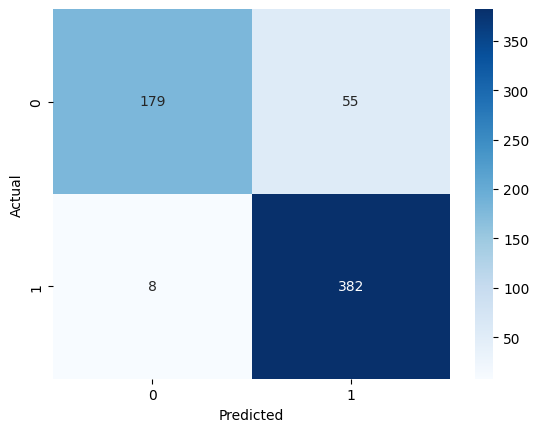

In [13]:
import seaborn as sns

cm = confusion_matrix(test_data.classes, pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
